In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.signal import lombscargle
from statsmodels.tsa.stattools import acf, pacf


def mat_to_pd(mat):
    """load matlab file and select trial variables"""
    mat = loadmat(mat)
    mat = {
        k: v.squeeze()
        for k, v in mat.items()
        if isinstance(v, np.ndarray) and v.shape == mat["RT"].shape
    }
    return pd.DataFrame(mat)


"""
variable descriptions
---------------------
coherence : float
    motion coherence of the trial, between 0-1
correct : 0 or 1
    0 if correct
    1 if error
RT : float
    response time to L/R from stimulus onset
dotDirection : 0 or pi
    direction of the motion, in radians
selectedDuration : float
    duration of the dot display, in seconds
    NaN = unlimited duration
waterSoFar : int
    amount of water consumed from start of session, in a.u.
proposedReward : float
    amount of water rewarded for correct trial, in a.u.
correctionTrial : 0 or 1
    0 if the motion direction was chosen randomly
    1 if the motion direction was the same as the previous failed trial
selectedDotSize : float
    size of dots, in stixels
selectedContrast : float
    constrast of the dots against the background, between 0-1
selectedSpeed : float
    speed of dots, in stixels per frame
proposedPenalty : float
    duration of timeout if error
pctCorrectionTrials : float
    probability of entering correction mode after error, between 0-1
isLoop : 0 or 1
    0 if movie does not loop until response
    1 if movie loops until rat responds
sessionNumber : int
    session is the span of time when rat had access to the game
"""


df195 = mat_to_pd("datasets/Rat195Vectors_241025.mat").assign(rat=195)
df196 = mat_to_pd("datasets/Rat196Vectors_241025.mat").assign(rat=196)
df = (
    pd.concat([df195, df196])
    .query("Valid == 1 and RT == RT")  # remove disqualified trials, and dropna
    .assign(trialDate=lambda x: pd.to_datetime(x["trialDate"] - 719529, unit="D"))
    .set_index("trialDate")
    .sort_index()
    .assign(coherence=lambda x: pd.cut(x["coherence"], bins=15, labels=False))  # discretize
)

df.groupby("rat")["RT"].count()

rat
195    108841
196    132743
Name: RT, dtype: int64

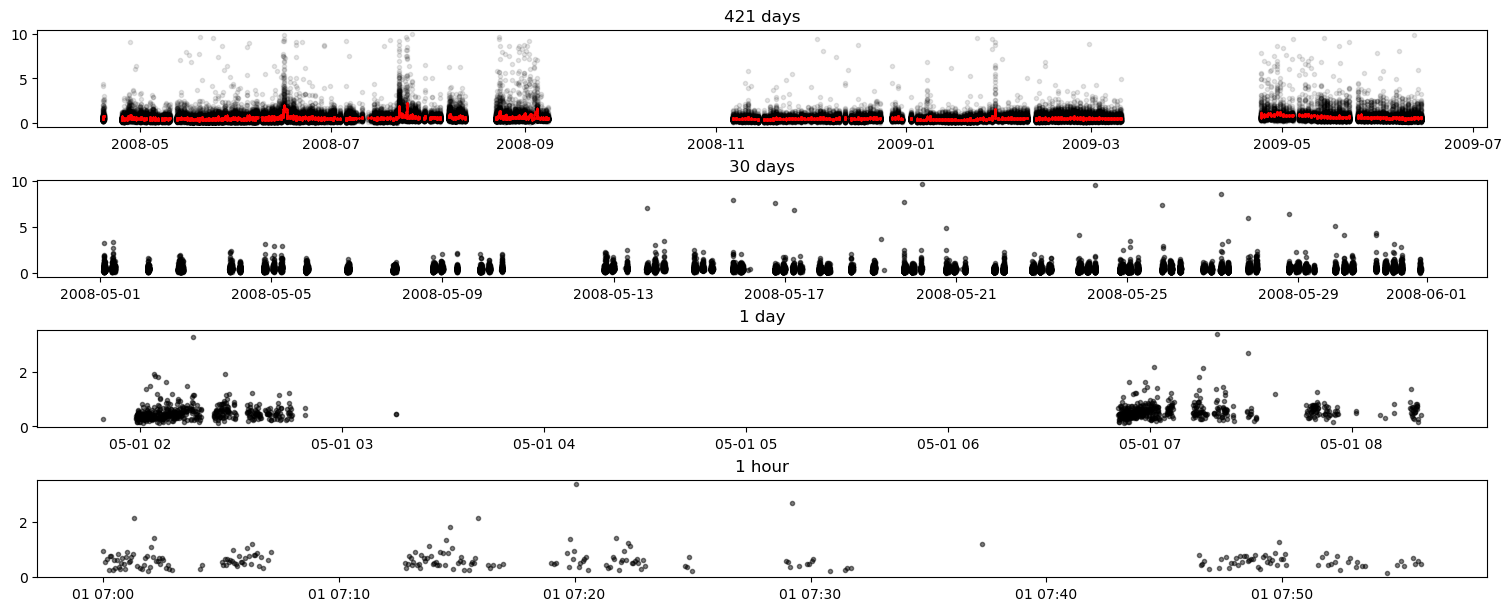

In [2]:
df = df.query("rat == 196")  # select rat 196 (for now)

fig, axs = plt.subplots(nrows=4, figsize=(15, 6), layout="constrained")

axs[0].set_title("421 days")
axs[0].plot(df["RT"], ".", c="k", alpha=0.1)
axs[0].plot(df["RT"].rolling(window=100).agg("mean"), ".", ms=0.5, c="r")

axs[1].set_title("30 days")
axs[1].plot(df.loc["2008-05"]["RT"], ".", c="k", alpha=0.5)

axs[2].set_title("1 day")
axs[2].plot(df.loc["2008-05-01"]["RT"], ".", c="k", alpha=0.5)

axs[3].set_title("1 hour")
axs[3].plot(df.loc["2008-05-01 07"]["RT"], ".", c="k", alpha=0.5)

<Axes: xlabel='Hour', ylabel='Date'>

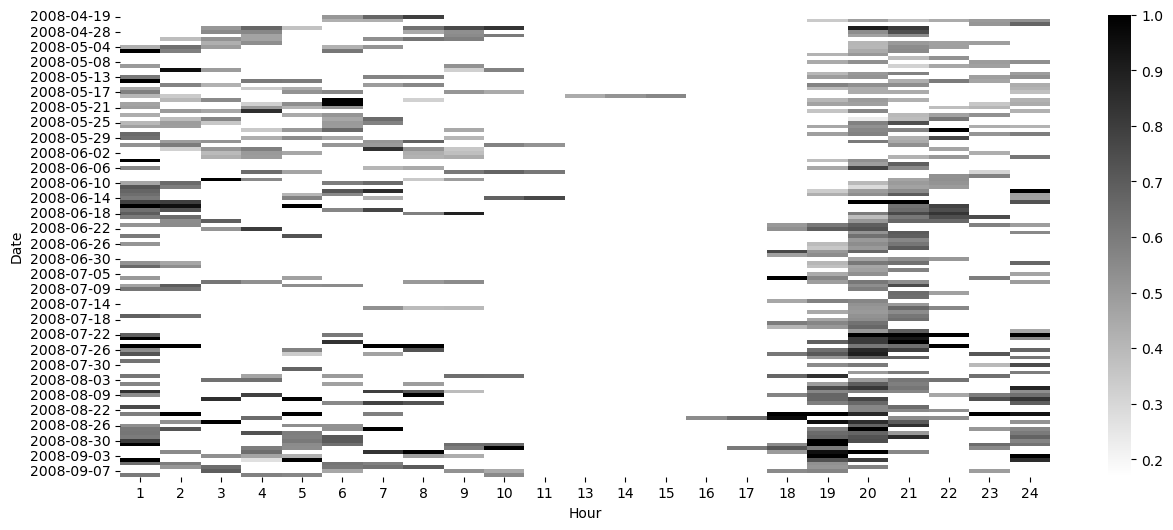

In [3]:
import seaborn as sns

df_heatmap = (
    df.loc["2008-04":"2008-09"]
    .assign(Date=lambda x: x.index.date, Hour=lambda x: x.index.hour + 1)
    .pivot_table(index="Date", columns="Hour", values="RT", aggfunc="mean")
)

fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(df_heatmap, cmap="binary", vmax=1, ax=ax)

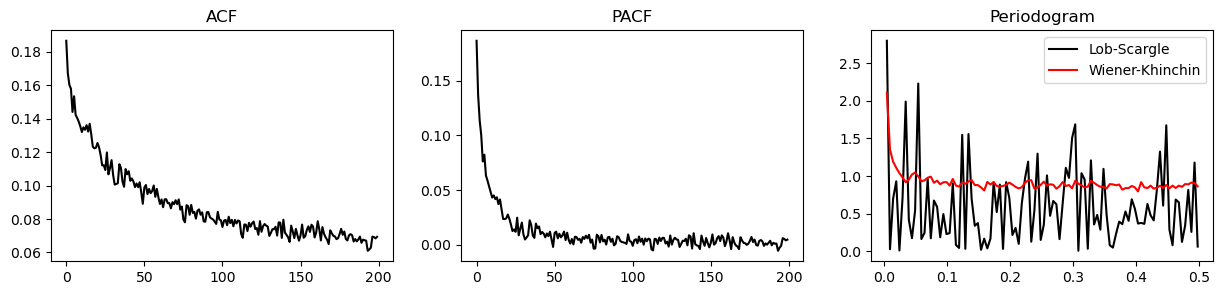

In [4]:
# ACF / PSD
fig, axs = plt.subplots(ncols=3, figsize=(15, 3), sharey=False)

n_lags = 200
acf_kwargs = dict(fft=True, bartlett_confint=False, missing="drop")
acf_ = acf(df["RT"], nlags=n_lags, **acf_kwargs)

freqs = np.fft.fftfreq(n_lags + 1)
mask = freqs > 0
freqs = freqs[mask]
powers_wk = np.fft.fft(acf_).real
powers_wk = powers_wk[mask]

axs[0].set_title("ACF")
axs[0].plot(acf_[1:], c="k")

axs[1].set_title("PACF")
axs[1].plot(pacf(df["RT"], nlags=n_lags)[1:], c="k")

# Lob-Scargle (LS) periodogram
# least squares fit of sine curves
freqs_angular = 2 * np.pi * freqs
powers_ls = lombscargle(x=df.index, y=df["RT"], freqs=freqs_angular)

axs[2].set_title("Periodogram")
axs[2].plot(freqs, powers_ls, c="k", label="Lob-Scargle")
axs[2].plot(freqs, powers_wk, c="r", label="Wiener-Khinchin")
axs[2].legend()

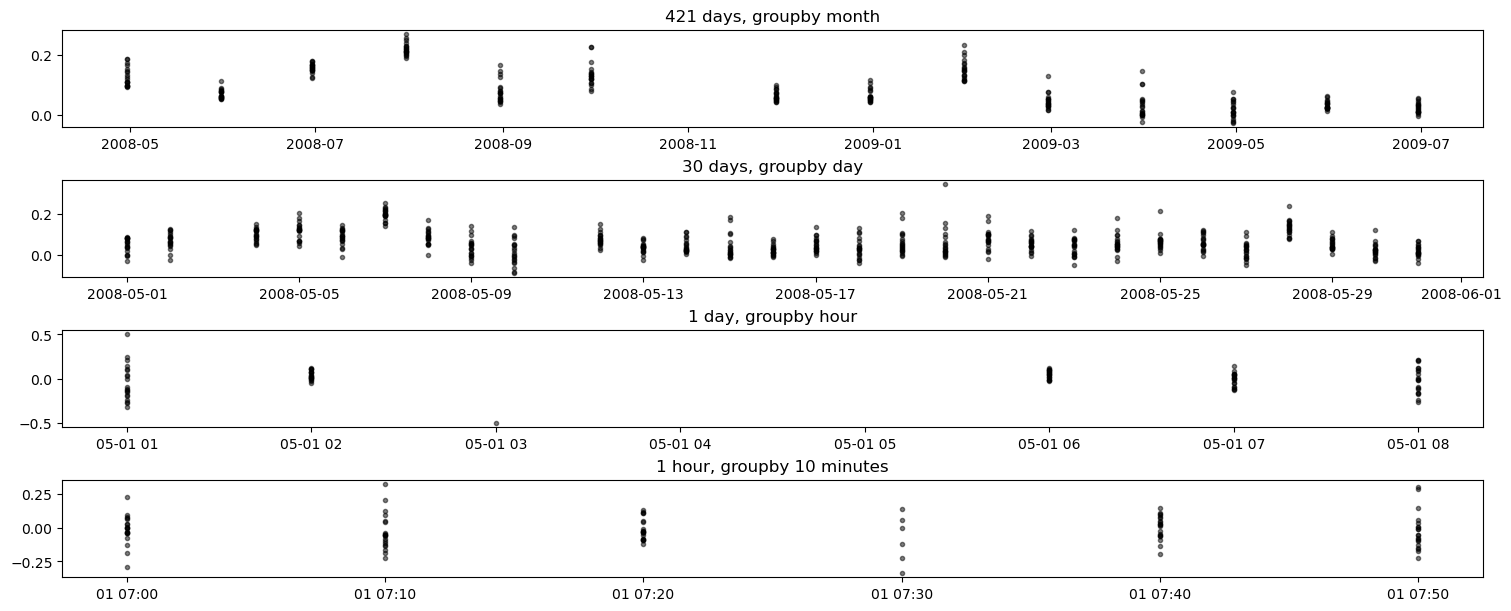

In [5]:
def acf_groupby(rt, freq):
    return (
        rt.groupby(pd.Grouper(freq=freq))
        .apply(lambda grp: np.nan if grp.empty else acf(grp, nlags=20, **acf_kwargs)[1:])
        .explode()
    )


fig, axs = plt.subplots(nrows=4, figsize=(15, 6), layout="constrained")

axs[0].set_title("421 days, groupby month")
axs[0].plot(acf_groupby(df["RT"], "ME"), ".", c="k", alpha=0.5)

axs[1].set_title("30 days, groupby day")
axs[1].plot(acf_groupby(df.loc["2008-05"]["RT"], "24h"), ".", c="k", alpha=0.5)

axs[2].set_title("1 day, groupby hour")
axs[2].plot(acf_groupby(df.loc["2008-05-01"]["RT"], "1h"), ".", c="k", alpha=0.5)


axs[3].set_title("1 hour, groupby 10 minutes")
axs[3].plot(acf_groupby(df.loc["2008-05-01 07"]["RT"], "10min"), ".", c="k", alpha=0.5)

/Users/griegner/git-repositories/drift-diffusion/.pixi/envs/dev/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


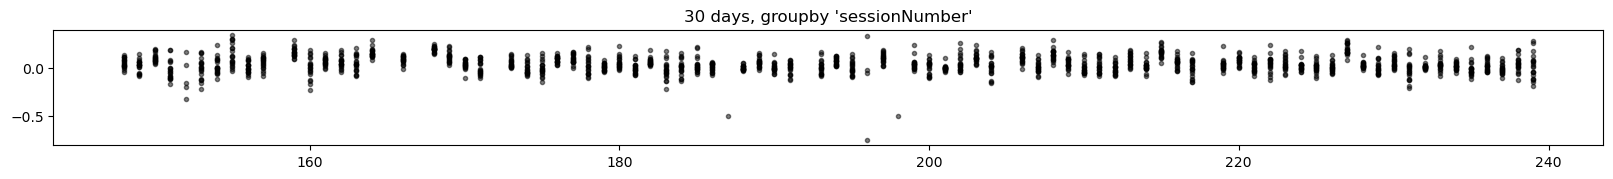

In [6]:
acf_by_session = (
    df.loc["2008-05"]
    .groupby("sessionNumber")["RT"]
    .apply(lambda grp: acf(grp, nlags=20, **acf_kwargs)[1:])
    .explode()
)

fig, ax = plt.subplots(figsize=(20, 6 / 4))
ax.set_title("30 days, groupby 'sessionNumber'")
ax.plot(acf_by_session, ".", c="k", alpha=0.5)

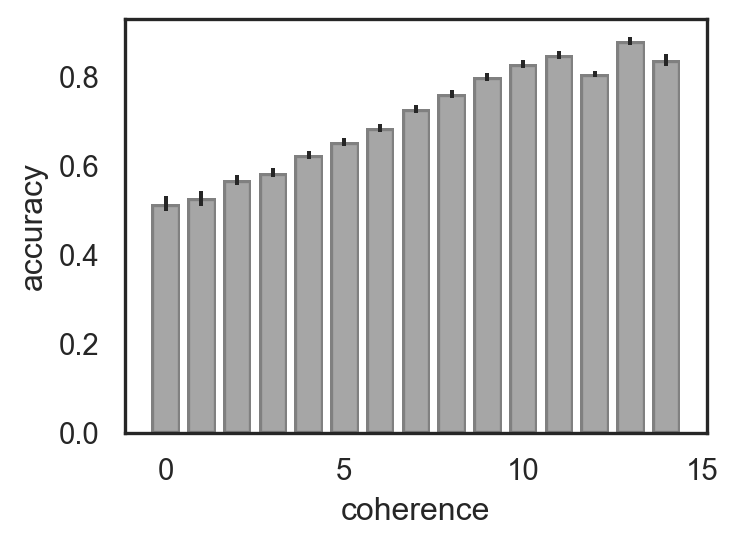

In [7]:
import seaborn.objects as so

# plot coherence vs accuracy
(
    so.Plot(df, x="coherence", y="correct")
    .add(so.Bar(color="gray"), so.Agg(func="mean"))
    .add(so.Range(color="k"), so.Est(errorbar="se"))
    .label(x="coherence", y="accuracy")
    .layout(size=(4, 3))
    .theme({"axes.facecolor": "white", "axes.edgecolor": "k"})
)

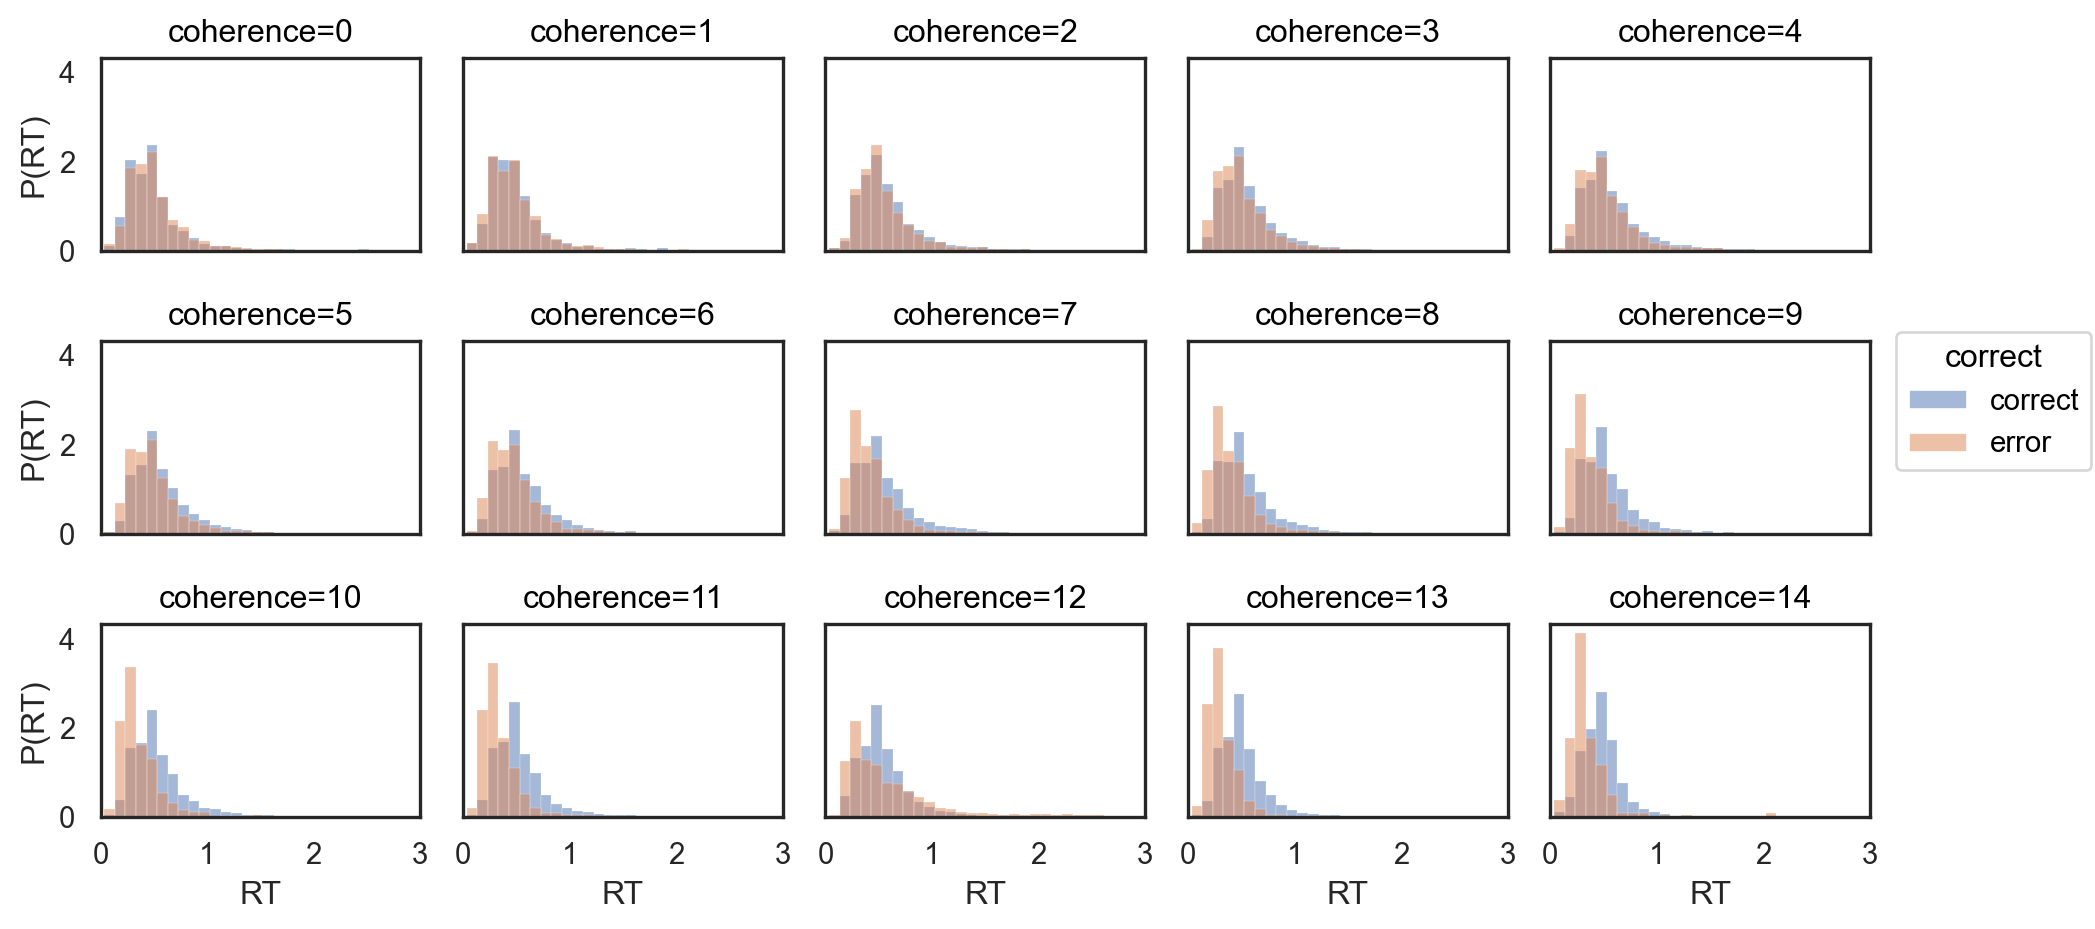

In [8]:
# plot rt distributions
(
    so.Plot(df, x="RT", color=df["correct"].map({1: "correct", 0: "error"}))
    .facet(col="coherence", wrap=5)
    .add(so.Bars(alpha=0.5), so.Hist(stat="density", bins=100))
    .limit(x=(0, 3))
    .layout(size=(10, 5))
    .label(x="RT", y="P(RT)", title="coherence={}".format)
    .theme({"axes.facecolor": "white", "axes.edgecolor": "k"})
)